In [60]:
from models.LeNet import LeNet
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch import nn

In [2]:
lenet = LeNet()

Model weights loaded successfully


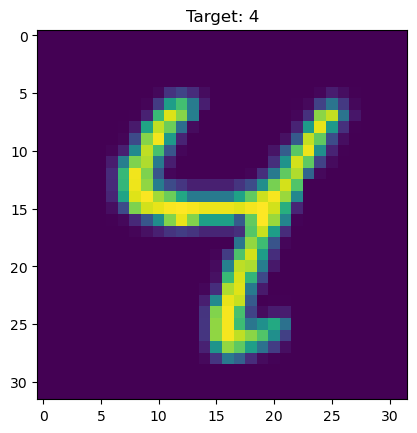

In [47]:
ex_num = 6
x0, y = lenet.test_dataset[ex_num]
x0_np = x0.squeeze()
plt.imshow(x0_np)
plt.title(f"Target: {y}")
plt.show()

In [61]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = lenet.model.to(device)
model.eval()

# Detatch PARAMETERS from computational graph
# This is so we dont waste time calculating gradient of params (only used for training)
# can still calulate grad wrt input wich is used for attacks
for param in model.parameters():
    param.requires_grad = False

# for target attacks you can define a custom loss here
criterion = nn.CrossEntropyLoss()#lenet.cost#

def input_grad(x_t):
    # Prepare the input tensor
    input_tensor = x_t.view(1, 1, 32, 32).to(device)
    input_tensor.requires_grad_()

    # Forward pass
    outputs = model(input_tensor)
    target_tensor = torch.tensor([y]).to(device)
    loss = criterion(outputs, target_tensor)
    _, predicted_class = outputs.max(1)

    # Backward pass to compute the gradients
    loss.backward()
    return input_tensor.grad, loss.item(), predicted_class.item()

input_gradient, _, _= input_grad(x0)
print(input_gradient)
torch.norm(input_gradient)

tensor([[[[ 1.1205e-07, -6.1321e-07,  8.4235e-06,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [-1.1365e-07, -3.0929e-07,  2.9758e-06,  ..., -6.7196e-07,
            0.0000e+00,  0.0000e+00],
          [-3.7308e-06,  6.9984e-07, -1.2199e-06,  ..., -3.1294e-07,
            0.0000e+00,  0.0000e+00],
          ...,
          [ 2.1634e-08, -4.0919e-08,  3.4889e-07,  ..., -6.1037e-07,
           -1.2602e-06,  0.0000e+00],
          [-4.2211e-08,  3.3172e-08,  2.4297e-07,  ..., -3.2375e-08,
           -1.4948e-06,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]]]])


tensor(0.0010)

# Frank-Wolfe White-box Attack Algorithm
As formulated by alg. 1 in attacks.pdf  
Different from standard FW because of momentum

In [67]:
eps = 0.5 # Max perturbation
max_iter = 1000
gamma_t = 1 # step size
beta = 0.5 # momentum term

# gradient does not need to be tracked in the FW
# is handeled in the input_gradient method
x_t = x0.detach().clone() 
m_t, _, _ = input_grad(x_t)
hist = []

for i in range(max_iter):
    g_t, loss_value, y_pred = input_grad(x_t)
    m_t = beta * m_t + (1 - beta) * g_t
    # LMO - for infinity norm
    v_t = -eps * m_t.sign() + x0
    d_t = v_t - x_t
    x_t = x_t + gamma_t*d_t

    # metrics
    hist.append({
        'loss': loss_value,
        'y_pred': y_pred
    })
hist = pd.DataFrame(hist)

In [68]:
hist[hist['y_pred'] != y]

,loss,y_pred
259,0.764623,5
536,2.449034,5
976,1.730069,5


<Axes: >

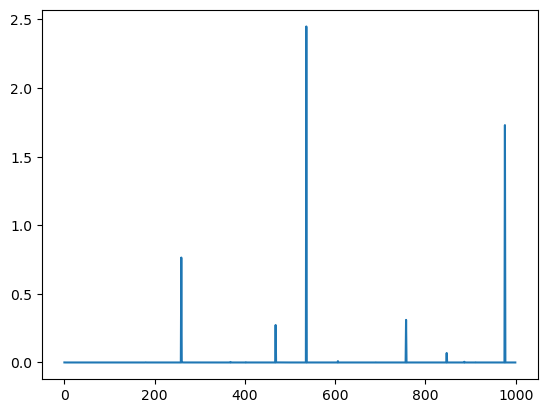

In [69]:
hist['loss'].plot()

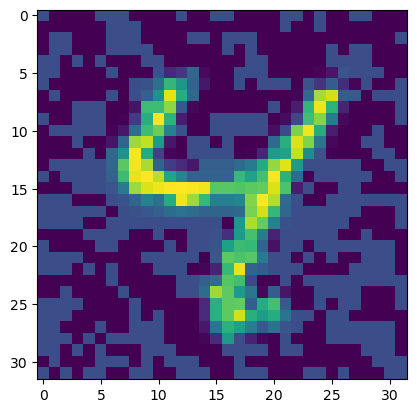

In [70]:
plt.imshow((x_t).squeeze())